RCNN发表于2013年，是首次将卷积网络用于目标检测的方法，其历史贡献在于：<br/>
1)首次将CNN用于目标检测的架构<br/>
2)当检测数据不足时，利用迁移学习的方法对于特征提取网络进行微调<br/>

RCNN的网络结构如下图，其推理过程为：首先利用selective search方法提取约2k张候选框，对于提取的候选框，采用各项异性缩放的方式将候选框尺寸缩放至224x224，将缩放后的候选框输入至CNN进行特征提取，然后输入至SVM（一共有k个SVM，k为类别数）进行类别判定，之后进行一次NMS过滤冗余候选框，最后将剩余的候选框输入至相应的回归器（一共有k个回归器，k为类别数）进行bbox回归。
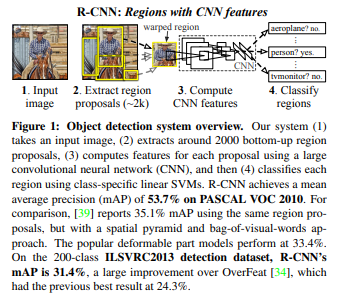

RCNN的训练过程如下：<br/>
1)首先用imagenet训练CNN作为预训练模型<br/>
2)然后用ss算法提取出候选框，对CNN进行微调，网络后面接一个softmax分类器，作者微调时采用128的batch-size，其中96个负样本，32个正样本（正负样本的划分标准为与任何一个gt的iou值大于0.5即判断为正样本，否则为负样本）；<br/>
3)训练SVM。利用one-to-rest策略，对于每一个类别训练一个SVM。首先用ss提取候选框，然后标定正负样本（正负样本的划分规则为iou与任何一个该类的gt的iou小于0.3即判定为负样本，gt为正样本，忽略iou在0.3与gt之间的候选框），之后用微调好的网络提取特征，作为svm的输入，最后对SVM进行训练。（作者在训练时采用了hard negative挖掘技术，所谓难负例，即难以判别的负例，一般只包含背景而不包含物体的候选框比较容易分类，而包含部分物体的候选框容易分成正类，属于难负例，难负例挖掘即每次预留出一部分负例，训练完一次svm，对预留出的负例进行分类，将其中分类错误的且对loss贡献较大的负例添加到训练样本中再次训练，如此迭代下去，直到满足终止条件）<br/>
4)训练bbox回归器。bbox回归即利用线性回归对预测框的位置进行修正，首先进行平移变换：
$$
\hat G_x = P_xdx + P_x \\
\hat G_y = P_yd_y + P_y
$$
然后进行尺度缩放：
$$
\hat G_w = P_w exp(d_w) \\
\hat G_h = P_h exp(d_h)
$$
$其中，P_*为预测框中心点坐标、宽高，\hat G_*为修正后的中心点坐标、宽高$<br/>
学习线性回归，输入是CNN提取的特征，输出是x,y的相对偏移与w,h的对数尺度的变换<br/>
$令\Phi_5(P)为CNN pooling5层提取的特征，要学习的线性变换为d_*(P) = w_*^T \Phi_5(P)，\\线性回归的目标函数为：$<br/>
$$
argmin\sum_{i=1}^{N}{[(t_*^i - w_*^T \Phi_5(P^i))^2 + \lambda ||w_*||^2]}
$$
$$
其中，
\begin {cases}
t_x = \frac{G_x - P_x}{P_w} \\
t_y = \frac{G_y - P_y}{P_h} \\
t_w = log \frac{G_w}{P_w} \\
t_x = log \frac{G_h}{P_h}
\end {cases}
,G_*为gt中心点及宽高
$$
注意，对于每张图片，只有与某个gt的iou值最大且大于0.6时才参与训练。<br/>
为什么可以用线性回归：<br/>
$首先，t_x与t_y为线性函数。其次，\lim_{x \to 0}{\frac{log(1+x)}{x}}=1，即x \rightarrow 0时，log(1+x) \approx x$<br/>
$t_w = log \frac{G_w}{P_w} = log \frac{G_w + P_w - P_w}{P_w} = log(1 + \frac{G_w - P_w}{P_w})，同理，t_h = log \frac{G_h}{P_h} = log \frac{G_h + P_h - P_h}{P_h} = log(1 + \frac{G_h - P_h}{P_h})，当预测框与gt的iou大于0.6时，预测框与gt宽高接近，\\则t_w与t_h也可看做线性函数$<br/>
x与y为什么用相对坐标：<br/>
$一般线性回归要将数据缩放到一定范围内（归一化），易于学习，如[0,1]，用相对偏移\\可将数据缩放到一定范围，同时满足尺寸不变性：如下面两个图，不同尺寸，但相对位置相同，\\若直接回归偏移量，则两个偏移量相差较大，模型不易于学习$
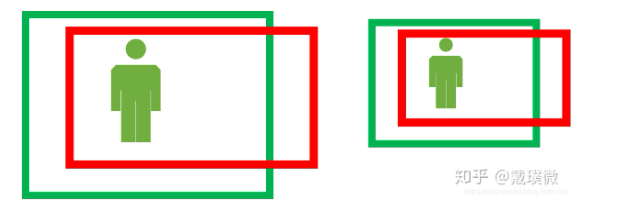
w与h为何用log尺寸：<br/>
同样是为了将数据缩放到一定范围，因为loss为MSE，因此为了避免中心点坐标或者宽高对于loss的贡献过大，二者的取值范围应近似，因此用log尺寸将宽高变化量调整到一定范围

其他细节：<br/>
1.图像缩放<br/>
1)"tightest square with context"：先在原始图像中，在候选区域周围裁剪出一个最小矩形，然后进行裁剪并缩放到224x224，如下图(B)<br/>
2)"tightest square without context"：先将图像裁剪出来，然后填充黑边正方形，然后缩放到224x224，如下图(C)<br/>
3)各项同性缩放，直接将候选框缩放值224x224，如下图(D)<br/>
作者经过实验，发现3)的效果最好。
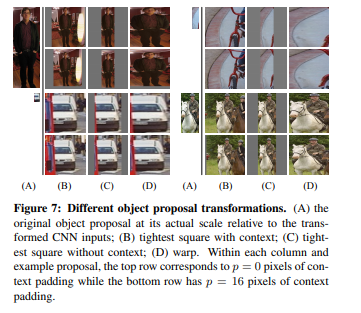